In [6]:
## Download and save the abstracts of all articles published since 2020 

from pathlib import Path
from curl_cffi import requests  
from bs4 import BeautifulSoup
import urllib.parse
import datetime
import re
import time
import pandas as pd

def get_chrome_headers():
    return {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
        'Accept': 'text/html,application/json,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Connection': 'keep-alive',
    }

def get_journal_issn(journal_title, my_email):
    try:
        endpoint = "/journals"
        query = f"query={urllib.parse.quote(journal_title)}"
        api_url = f"https://api.crossref.org{endpoint}?{query}"
        print(f"Querying URL for {journal_title} ISSN: {api_url}")

        headers = get_chrome_headers()
        headers['mailto'] = my_email
        
        api_response = requests.get(api_url, headers=headers)
        print(f"CrossRef server responded with status code: {api_response.status_code}")
        
        if api_response.status_code != 200:
            print(f"Failed to retrieve ISSN for {journal_title}. Status code: {api_response.status_code}")
            return None
        
        journal_json = api_response.json()
        issn_list = []
        
        for item in journal_json["message"]["items"]:
            if item["title"].lower() == journal_title.lower():
                issn_list.extend(item.get("ISSN", []))
                break
        
        if not issn_list:
            print(f"No ISSN found for {journal_title}. Check the journal title or CrossRef data.")
            return None
        
        return issn_list[0] if issn_list else None
    except Exception as e:
        print(f"Error getting ISSN for {journal_title}: {e}")
        return None


In [57]:
#Retrieve Publications from ISSN

def get_journal_articles(issn, from_date, until_date, rows_per_query, my_email):
    try:
        endpoint = f"/journals/{issn}/works"
        # Properly structure the query parameters
        params = {
            'filter': f'from-pub-date:{from_date},until-pub-date:{until_date}',
            'rows': rows_per_query,
            'mailto': my_email
        }
        
        api_url = f"https://api.crossref.org{endpoint}"
        print(f"Querying works for ISSN {issn}")
        
        headers = get_chrome_headers()
        headers['mailto'] = my_email
        
        api_response = requests.get(api_url, params=params, headers=headers)
        print(f"Full URL being queried: {api_response.url}")
        print(f"CrossRef server responded with status code: {api_response.status_code}")
        
        if api_response.status_code != 200:
            print(f"Failed to retrieve works for ISSN {issn}. Status code: {api_response.status_code}")
            return None
        
        works_json = api_response.json()
        if "message" not in works_json or "items" not in works_json["message"]:
            print(f"Unexpected API response structure for ISSN {issn}.")
            return None
        
        total_results = works_json["message"]["total-results"]
        print(f"Total works found for ISSN {issn}: {total_results}")
        
        return works_json
    except Exception as e:
        print(f"Error getting articles for ISSN {issn}: {e}")
        return None

def parse_article(article):
    try:
        doi = article["DOI"]
        title = article.get("title", ["N/A"])[0] if article.get("title") else "N/A"
        pub_date = build_date(article["published"]["date-parts"])
        journal_name = article.get("container-title", ["N/A"])[0] if article.get("container-title") else "N/A"
        raw_abstract = article.get("abstract", "N/A")
        
        if raw_abstract and raw_abstract != "N/A":
            try:
                soup = BeautifulSoup(raw_abstract, "html5lib")
                abstract = soup.get_text().strip()
                if not abstract:
                    abstract = "Abstract provided but could not be parsed"
            except Exception as e:
                print(f"Error parsing abstract for article '{title}': {e}")
                abstract = "Abstract provided but parsing failed"
        else:
            abstract = "No abstract provided"
    
        return {
            "doi": doi,
            "title": title,
            "journal_name": journal_name,
            "abstract": abstract,
            "pub_year": pub_date.year if pub_date else "N/A",
        }
    except Exception as e:
        print(f"Error parsing article '{article.get('title', ['N/A'])[0]}' (DOI: {article.get('DOI', 'N/A')}): {e}")
        return None

def build_date(date_parts):
    if len(date_parts[0]) == 3:
        year, month, day = date_parts[0]
    else:
        year, month = date_parts[0]
        day = 1
    return datetime.datetime(year, month, day)

def save_articles_to_csv(articles_data, output_dir, filename="parsed_articles.csv"):
    output_path = Path(output_dir) / filename
    df = pd.DataFrame(articles_data)
    df.to_csv(output_path, index=False, encoding="utf-8")
    print(f"✅ Saved all parsed articles to {output_path}")

def process_journals(journal_list, from_date, until_date, rows_per_query, my_email):
    all_articles = []
    
    for journal_title in journal_list:
        try:
            print(f"\nProcessing {journal_title}")
            issn = get_journal_issn(journal_title, my_email)
            if not issn:
                continue
            articles_json = get_journal_articles(issn, from_date, until_date, rows_per_query, my_email)
            if not articles_json:
                continue

            articles_processed = 0
            
            for article in articles_json["message"]["items"]:
                parsed_article = parse_article(article)
                if parsed_article:
                    all_articles.append(parsed_article)
                    articles_processed += 1
                time.sleep(0.5)  
            
            print(f"Journal: {journal_title}")
            print(f"Articles processed: {articles_processed}")
            
        except Exception as e:
            print(f"Error processing {journal_title}: {e}")
            continue

    if all_articles:
        df = pd.DataFrame(all_articles)
        print(f"Total articles collected: {len(df)}")
        return df
    else:
        print("No articles were collected.")
        return pd.DataFrame()


In [ ]:
my_email = "li454273@ucf.edu"
journal_list = ["Strategic Management Journal", "Personnel Psychology"]
from_date = "2020-01-01"
until_date = "2025-02-11"
rows_per_query = 1000

results_df = process_journals(journal_list, from_date, until_date, rows_per_query, my_email)
if not results_df.empty:
    output_file = f"five_years_api.csv"
    results_df.to_csv(output_file, encoding="utf-8-sig", index=False, header=True)
    print(f"Saved articles to {output_file}")
else:
    print("No data to save.")


Processing Strategic Management Journal
Querying URL for Strategic Management Journal ISSN: https://api.crossref.org/journals?query=Strategic%20Management%20Journal
CrossRef server responded with status code: 200
Querying works for ISSN 0143-2095
Full URL being queried: https://api.crossref.org/journals/0143-2095/works?filter=from-pub-date%3A2020-01-01%2Cuntil-pub-date%3A2025-02-11&rows=1000&mailto=li454273%40ucf.edu
CrossRef server responded with status code: 200
Total works found for ISSN 0143-2095: 635
Journal: Strategic Management Journal
Articles processed: 635

Processing Personnel Psychology
Querying URL for Personnel Psychology ISSN: https://api.crossref.org/journals?query=Personnel%20Psychology
CrossRef server responded with status code: 200
Querying works for ISSN 0031-5826
Full URL being queried: https://api.crossref.org/journals/0031-5826/works?filter=from-pub-date%3A2020-01-01%2Cuntil-pub-date%3A2025-02-11&rows=1000&mailto=li454273%40ucf.edu
CrossRef server responded with

In [60]:
# Define patterns to remove
# Read the existing CSV file
df = pd.read_csv("five_years_api.csv")

def clean_abstract(text):
    # Handle NaN or invalid entries
    if pd.isna(text) or text in ["No abstract provided", "Abstract provided but could not be parsed", "Abstract provided but parsing failed"]:
        return ""
    
    # Remove HTML tags if any remain
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove abstract prefixes
    prefix_patterns = [
        r'^Abstract\s*',  # Matches "Abstract" at start
        r'^AbstractResearch Summary\s*',  # Matches "AbstractResearch Summary" at start
        r'^Research Summary\s*',  # Matches "Research Summary" at start
        r'^Summary\s*',  # Matches "Summary" at start
        r'^Abstract[\s:-]*',  # Matches "Abstract" followed by spaces, colons, or hyphens
    ]
    
    for pattern in prefix_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)  # Case insensitive
    
    # Remove copyright patterns
    copyright_patterns = [
        r'©.*?\d{4}.*?\.',  
        r'Copyright ©.*?\.',  
        r'All rights reserved.*?\.',  
        r'Copyright.*?\.',  
        r'\([cC]\).*?\.'
    ]
    
    for pattern in copyright_patterns:
        text = re.sub(pattern, '', text)
    
    # Clean extra whitespace and special characters
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single space
    text = re.sub(r'[\r\n\t]', ' ', text)  # Remove newlines, returns, tabs
    text = re.sub(r'[^a-zA-Z0-9\s.,;:!?()-]', '', text)  # Remove special chars but keep basic punctuation
    
    return text.strip()

# Clean the abstracts
df['abstract'] = df['abstract'].apply(clean_abstract)

# Sort by publication year
df = df.sort_values('pub_year', ascending=True)
df = df.dropna(subset=['abstract']).query("abstract.str.strip() != ''")

# Save the cleaned and sorted data
df.to_csv("five_years_api.csv", index=False, encoding="utf-8-sig")


In [61]:
import os
import re
import openai
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the CSV file
csv_path = os.path.expanduser("five_years_api.csv")
df = pd.read_csv(csv_path)

# Ensure 'abstract' column exists
if 'abstract' not in df.columns:
    raise ValueError("Error: CSV file does not contain an 'abstract' column.")

# Define preprocessing function
def preprocess(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return " ".join(filtered_tokens)

# Apply preprocessing to abstracts
df["abstract"] = df["abstract"].astype(str).apply(preprocess)

# Save the preprocessed data
df.to_csv(csv_path, index=False, encoding="utf-8")

print("csv file cleaned")

csv file cleaned


In [51]:
# Compute TF-IDF embeddings
abstracts = df["abstract"].astype(str).tolist()
vectorizer = TfidfVectorizer(max_features=5000) 
tfidf_matrix = vectorizer.fit_transform(abstracts)

# Convert to array
tfidf_embeddings = tfidf_matrix.toarray()

# Check shape
print("TF-IDF Embedding Shape:", tfidf_embeddings.shape)

TF-IDF Embedding Shape: (246, 5000)


In [62]:
# Load API key from .env file
load_dotenv()
api_key = os.getenv("OPENAI_KEY")

client = openai.OpenAI(api_key=api_key) 

def get_openai_embedding(text):
    """Obtain embeddings using GPT-4o-mini."""
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"  
    )
    return response.data[0].embedding 
    
abstracts = df["abstract"].tolist()  # Convert column to list
openai_embeddings = np.array([get_openai_embedding(abstract) for abstract in abstracts])

# Add embeddings to the DataFrame
df["embedding"] = openai_embeddings.tolist()

# Print shape of the embedding array
print("OpenAI Embedding Shape:", openai_embeddings.shape)

OpenAI Embedding Shape: (643, 1536)


In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X = df["abstract"]
y = df["journal_name"] 

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Feature Extraction
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model 1: Random Forest
rf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}

rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Random Forest Performance:")
print(classification_report(y_test, rf_grid.best_estimator_.predict(X_test)))

Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
Random Forest Performance:
                              precision    recall  f1-score   support

        Personnel Psychology       1.00      0.60      0.75        30
Strategic Management Journal       0.89      1.00      0.94        99

                    accuracy                           0.91       129
                   macro avg       0.95      0.80      0.85       129
                weighted avg       0.92      0.91      0.90       129



In [64]:
# Model 2: Support Vector Machine (SVM)
svm_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SVC())
])

svm_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)

print("Best parameters for SVM:", svm_grid.best_params_)
print("SVM Performance:")
print(classification_report(y_test, svm_grid.best_estimator_.predict(X_test)))

Best parameters for SVM: {'classifier__C': 10, 'classifier__kernel': 'linear'}
SVM Performance:
                              precision    recall  f1-score   support

        Personnel Psychology       0.96      0.87      0.91        30
Strategic Management Journal       0.96      0.99      0.98        99

                    accuracy                           0.96       129
                   macro avg       0.96      0.93      0.94       129
                weighted avg       0.96      0.96      0.96       129



In [65]:
# OpenAI Embeddings
X_train_embed = np.array([get_openai_embedding(text) for text in X_train])
X_test_embed = np.array([get_openai_embedding(text) for text in X_test])

# Train models using embeddings
rf_embed = RandomForestClassifier(n_estimators=200, max_depth=None)
rf_embed.fit(X_train_embed, y_train)
print("Random Forest (Embedding) Performance:")
print(classification_report(y_test, rf_embed.predict(X_test_embed)))

svm_embed = SVC(C=1, kernel='linear')
svm_embed.fit(X_train_embed, y_train)
print("SVM (Embedding) Performance:")
print(classification_report(y_test, svm_embed.predict(X_test_embed)))

Random Forest (Embedding) Performance:
                              precision    recall  f1-score   support

        Personnel Psychology       1.00      0.63      0.78        30
Strategic Management Journal       0.90      1.00      0.95        99

                    accuracy                           0.91       129
                   macro avg       0.95      0.82      0.86       129
                weighted avg       0.92      0.91      0.91       129

SVM (Embedding) Performance:
                              precision    recall  f1-score   support

        Personnel Psychology       1.00      0.87      0.93        30
Strategic Management Journal       0.96      1.00      0.98        99

                    accuracy                           0.97       129
                   macro avg       0.98      0.93      0.95       129
                weighted avg       0.97      0.97      0.97       129



In [90]:
# Obtain 20 abstracts from the Journal of Management that the model was not trained on
new_journal = ["Journal of Management"]
new_from = "2024-01-01"
new_until = "2024-12-31"
n_rows = 20

results_df = process_journals(new_journal, new_from, new_until, n_rows, my_email)
if not results_df.empty:
    new_output = "JOM_abstracts.csv"
    results_df.to_csv(new_output, encoding="utf-8-sig", index=False, header=True)
    print(f"Saved new abstracts to {new_output}")
else:
    print("No new data to save.")



Processing Journal of Management
Querying URL for Journal of Management ISSN: https://api.crossref.org/journals?query=Journal%20of%20Management
CrossRef server responded with status code: 200
Querying works for ISSN 0149-2063
Full URL being queried: https://api.crossref.org/journals/0149-2063/works?filter=from-pub-date%3A2024-01-01%2Cuntil-pub-date%3A2024-12-31&rows=20&mailto=li454273%40ucf.edu
CrossRef server responded with status code: 200
Total works found for ISSN 0149-2063: 108
Journal: Journal of Management
Articles processed: 20
Total articles collected: 20
Saved new abstracts to JOM_abstracts.csv


In [91]:
# Clean the JOM abstracts
JOM_abstracts_df = pd.read_csv("JOM_abstracts.csv")
JOM_abstracts_df["abstract"] = JOM_abstracts_df["abstract"].apply(clean_abstract)
JOM_abstracts_df = JOM_abstracts_df.dropna(subset=['abstract']).query("abstract.str.strip() != ''")
JOM_abstracts_df.to_csv("JOM_abstracts.csv", index=False, encoding="utf-8-sig")

In [95]:
# Predict categories for new abstracts
JOM_abstracts_df["embedding"] = JOM_abstracts_df["abstract"].apply(get_openai_embedding)

X_new_embed = np.vstack(JOM_abstracts_df["embedding"])
JOM_abstracts_df["svm_openAI"] = svm_embed.predict(X_new_embed)

print("Predictions for new abstracts:")
print(JOM_abstracts_df[["abstract", "svm_openAI"]])

Predictions for new abstracts:
                                             abstract  \
0   In the mentoring relationship, protg proactivi...   
1   Employees daily routines (e.g., commutes, lunc...   
2   Building and deploying a minimum viable produc...   
3   This research investigates how entrepreneurs i...   
4   Scholars have started unpacking how individual...   
5   We extend event system theory (EST) to concept...   
6   Structures involve a patterned regularity of i...   
7   Advice is often given to junior scholars in th...   
8   This special issue explores the transformative...   
9   How do individual independent directors make s...   
10  New roles birthed by organizational inclusion ...   
11  Over the past half century, virtual interactio...   
12  Recent scholarship has sought to develop a sci...   
13  The detrimental influence of cognitive biases ...   
14  Since its introduction more than four decades ...   
15  Companies strive to gain a competitive advanta...   


In [96]:
JOM_abstracts_df.drop(columns=["embedding"], inplace=True)
JOM_abstracts_df.to_csv("JOM_abstracts.csv", index=False, encoding="utf-8-sig")
print("Updated predictions appended to JOM_abstracts.csv")

Updated predictions appended to JOM_abstracts.csv


Evaluation for SVM model:
Accuracy: 0.8889
Classification Report:
                              precision    recall  f1-score   support

        Personnel Psychology       0.89      0.89      0.89         9
Strategic Management Journal       0.89      0.89      0.89         9

                    accuracy                           0.89        18
                   macro avg       0.89      0.89      0.89        18
                weighted avg       0.89      0.89      0.89        18



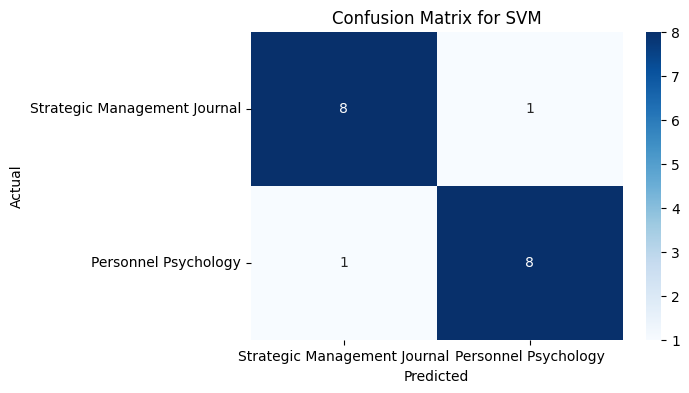

In [97]:
# Compare the ML models and manual coding
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

JOM_abstracts_df = pd.read_csv("JOM_abstracts.csv")
JOM_abstracts_df["manual_agreed"] = JOM_abstracts_df["manual_agreed"].astype(str)

def evaluate_model(trained_column, model_name):
    print(f"Evaluation for {model_name} model:")
    print(f"Accuracy: {accuracy_score(JOM_abstracts_df['manual_agreed'], JOM_abstracts_df[trained_column]):.4f}")
    print("Classification Report:")
    print(classification_report(JOM_abstracts_df["manual_agreed"], JOM_abstracts_df[trained_column]))

    cm = confusion_matrix(JOM_abstracts_df["manual_agreed"], JOM_abstracts_df[trained_column])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(JOM_abstracts_df["manual_agreed"]), yticklabels=set(JOM_abstracts_df["manual_agreed"]))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

evaluate_model("svm_openAI", "SVM")